In [1]:
import getpass  # to get the password without showing the input
password = getpass.getpass()

········


In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
connection_string_2 = 'mysql+pymysql://root:' + password + '@localhost/demo_db'

engine = create_engine(connection_string)
engine_2 = create_engine(connection_string_2)

Notes:
- category_id will have to be stored as a string

### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [4]:
query1 = '''
with cte3 as(
select distinct f.film_id, count(r.inventory_id) as count_rentals, f.release_year, f.rental_rate, f.rating
from film f
left join inventory i 
on i.film_id = f.film_id
left join rental r 
on i.inventory_id = r.inventory_id
left join film_category fc
on f.film_id = fc.film_id
group by f.film_id)
select cte3.film_id, cte3.count_rentals, cte3.release_year, cte3.rental_rate, cte3.rating, fc.category_id
from cte3
left join film_category fc
on cte3.film_id = fc.film_id
'''
features = pd.read_sql_query(query1, engine)
features.head(3)

,film_id,count_rentals,release_year,rental_rate,rating,category_id
0,1,23,2006,0.99,PG,6
1,2,7,2006,4.99,G,11
2,3,12,2006,2.99,NC-17,6


### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

1. We first get a df and a list with the film_id of all the films that were rented in the last month

In [5]:
query2 = '''
select f.film_id, year(r.rental_date) as year,  month(r.rental_date) as month
from film f
left join inventory i 
on i.film_id = f.film_id
left join rental r 
on i.inventory_id = r.inventory_id
where year(r.rental_date) = (
with cte1 as(
select distinct year(rental_date) as year, month(rental_date) as month, dense_rank() over(order by year(rental_date) desc, month(rental_date) desc) as ranking
from rental),
cte2 as(
select *
from cte1
where ranking = 1)
select year from cte2
)
and month(r.rental_date) = (
with cte1 as(
select distinct year(rental_date) as year, month(rental_date) as month, dense_rank() over(order by year(rental_date) desc, month(rental_date) desc) as ranking
from rental),
cte2 as(
select *
from cte1
where ranking = 1)
select month from cte2
)
'''
df_last_month_film_id_rented = pd.read_sql_query(query2, engine)
last_month_film_id_rented = df_last_month_film_id_rented['film_id'].tolist()

2. We then create a list with all the film_id

In [6]:
query3 = '''
select distinct film_id
from film
'''
df_all_film_id = pd.read_sql_query(query3, engine)
all_film_id = df_all_film_id['film_id'].tolist()

3. We create a function that checks if a film_id was rented last month or not

In [7]:
df_all_film_id.head(3)

def last_month_rented(x):
    x['rented_last_month']=0
    for i in range(len(x.index)):
        if x['film_id'][i] in last_month_film_id_rented:
            x['rented_last_month'].iloc[i] = 'true'
        else: 
            x['rented_last_month'].iloc[i] = 'false'


In [8]:
last_month_rented(df_all_film_id)
df_all_film_id

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,film_id,rented_last_month
0,1,false
1,2,true
2,3,false
3,4,true
4,5,true
...,...,...
995,996,false
996,997,false
997,998,true
998,999,false


### 2- Read the data into a Pandas dataframe

According to the workflow I have followed so far, I will use this step to merge the data I will use to make predictions and the target variable in one same df.

In [9]:
print(features.head(3), "\n\n", features.shape, "\n\n", df_all_film_id.head(3),"\n\n",df_all_film_id.shape)

   film_id  count_rentals  release_year  rental_rate rating  category_id
0        1             23          2006         0.99     PG            6
1        2              7          2006         4.99      G           11
2        3             12          2006         2.99  NC-17            6 

 (1000, 6) 

    film_id rented_last_month
0        1             false
1        2              true
2        3             false 

 (1000, 2)


In [10]:
df = features.merge(df_all_film_id, on='film_id')
df

,film_id,count_rentals,release_year,rental_rate,rating,category_id,rented_last_month
0,1,23,2006,0.99,PG,6,false
1,2,7,2006,4.99,G,11,true
2,3,12,2006,2.99,NC-17,6,false
3,4,23,2006,2.99,G,11,true
4,5,12,2006,2.99,G,8,true
...,...,...,...,...,...,...,...
995,996,7,2006,0.99,G,6,false
996,997,6,2006,0.99,NC-17,12,false
997,998,9,2006,0.99,NC-17,11,true
998,999,17,2006,2.99,R,3,false


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

#### Lets check null values:

In [11]:
nulls = pd.DataFrame(df.isna().sum()*100/len(df), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

,percentage
film_id,0.0
count_rentals,0.0
release_year,0.0
rental_rate,0.0
rating,0.0
category_id,0.0
rented_last_month,0.0


#### Check data types and adjust them if they are not appropiate.
    - release_year: num to cat
    - category_id: num to cat

In [12]:
df.dtypes

film_id                int64
count_rentals          int64
release_year           int64
rental_rate          float64
rating                object
category_id            int64
rented_last_month     object
dtype: object

In [13]:
df.category_id = df.category_id.astype(object)
df.release_year = df.release_year.astype(object)
df.dtypes

film_id                int64
count_rentals          int64
release_year          object
rental_rate          float64
rating                object
category_id           object
rented_last_month     object
dtype: object

#### Checking data imbalances for categoricals

In [14]:
df['rating'].value_counts()
## quite evenly spread, no need for bucketing or anything else to clean data

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [15]:
df['category_id'].value_counts()
## quite evenly spread, no need for bucketing or anything else to clean data

15    74
9     73
8     69
6     68
2     66
1     64
13    63
7     62
10    61
14    61
3     60
5     58
4     57
16    57
11    56
12    51
Name: category_id, dtype: int64

In [16]:
df['rented_last_month'].value_counts()
## Target variable data is very imbalanced

false    832
true     168
Name: rented_last_month, dtype: int64

#### Plotting numerical columns

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


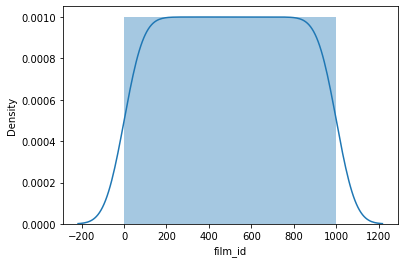

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


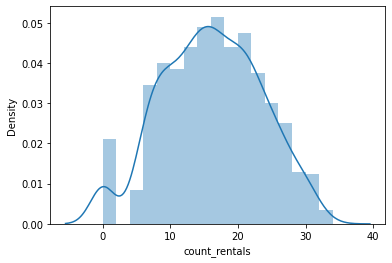

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


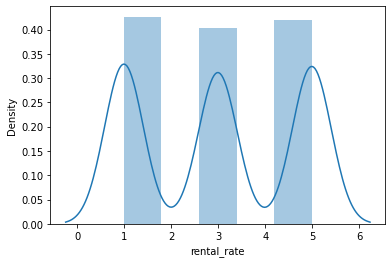

In [17]:
for col in df.select_dtypes(np.number):
    sns.distplot(df[col])
    plt.show()

#### Setting film_id as index

In [18]:
df = df.set_index('film_id')

### 5- Create a logistic regression model to predict this variable from the cleaned data

#### x-Y split

In [19]:
y = df['rented_last_month']
X = df.drop('rented_last_month', axis=1)

#### encoding categoricals

In [20]:
df.dtypes

count_rentals          int64
release_year          object
rental_rate          float64
rating                object
category_id           object
rented_last_month     object
dtype: object

In [21]:
X = pd.get_dummies(X, columns=['release_year', 'rating', 'category_id'])
X

,count_rentals,rental_rate,release_year_2006,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_1,category_id_2,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
film_id,,,,,,,,,,,,,,,,,,,,,
1,23,0.99,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,4.99,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,12,2.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,2.99,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,12,2.99,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,7,0.99,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,6,0.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
998,9,0.99,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [24]:
classification.score(X_test, y_test)

0.88

In [25]:
predictions = classification.predict(X_test)
predictions

array(['false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'false', 'false', 'false', 'false', 'false',
       'false', 'fal

In [26]:
confusion_matrix(y_test, predictions)

array([[176,   0],
       [ 24,   0]])

In [27]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')

<AxesSubplot:>

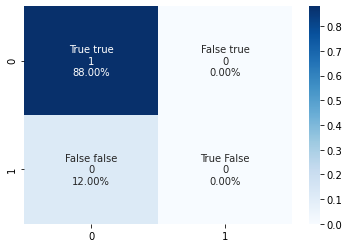

In [28]:
group_names = ['True true', 'False true', 'False false', 'True False']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#### Balancing target variable

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X, y = smote.fit_resample(X, y)
y.value_counts()

false    832
true     832
Name: rented_last_month, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
classification.score(X_test, y_test)

0.9009009009009009

In [33]:
predictions = classification.predict(X_test)
predictions

array(['true', 'false', 'false', 'true', 'false', 'false', 'true', 'true',
       'true', 'false', 'true', 'false', 'false', 'false', 'true', 'true',
       'false', 'false', 'false', 'true', 'false', 'false', 'true',
       'false', 'true', 'true', 'false', 'false', 'false', 'true',
       'false', 'false', 'true', 'false', 'true', 'false', 'true',
       'false', 'true', 'true', 'false', 'false', 'false', 'true',
       'false', 'false', 'false', 'false', 'false', 'true', 'false',
       'true', 'false', 'true', 'true', 'false', 'false', 'false',
       'false', 'true', 'false', 'false', 'true', 'false', 'false',
       'false', 'false', 'false', 'false', 'true', 'true', 'true',
       'false', 'false', 'false', 'true', 'false', 'false', 'true',
       'false', 'false', 'false', 'false', 'true', 'true', 'false',
       'false', 'false', 'true', 'false', 'false', 'true', 'true', 'true',
       'false', 'true', 'false', 'false', 'false', 'false', 'false',
       'false', 'false', 'fals

In [38]:
confusion_matrix(y_test, predictions)
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')

<AxesSubplot:>

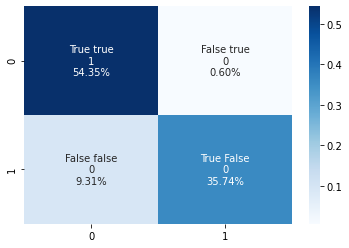

In [39]:
group_names = ['True true', 'False true', 'False false', 'True False']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

After balancing the data we are:
- Less precise with our predictions of films that were rented  
- More precise with our predictions of films that were not rented 

In general, balancing data has been positive as we have a less biased model